In [17]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load data in ##

In [100]:
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190629.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190622.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt')
df4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190608.txt')
june_data_raw = pd.concat([df1,df2,df3,df4], ignore_index = True)

## Cleaning: ##

Fix column names by clarifying entries and exits are cumulative, add a combined datetime column, get rid of times that aren't on the hour (these seem to have weird results that throw the others off)

In [101]:
june_data_raw.rename(columns={'EXITS                                                               ':"CU_EXITS", \
                          'ENTRIES': 'CU_ENTRIES'}, inplace=True)
june_data_raw['DATETIME'] = pd.to_datetime(june_data_raw['DATE'] + ' ' + june_data_raw['TIME'])
june_data_raw = june_data_raw[(june_data_raw['DATETIME'].dt.minute==0)&(june_data_raw['DATETIME'].dt.second==0)].copy()

## Processing ##

In [105]:
#Group the turnstile data together by datetime, not sure if this is necessary since each turnstile at each time 
#only appears once, may be able to get rid of this
june_data = (june_data_raw.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", 'TIME'],as_index=False)
            [['CU_ENTRIES','CU_EXITS']].last())

In [106]:
#Add columns for entries since the last timestep for each turnstile
june_data[['ENTRIES','EXITS']] = (june_data
                                          .groupby(["C/A", "UNIT", "SCP", "STATION"])[[ "CU_ENTRIES", 'CU_EXITS']]
                                          .apply(lambda x: x.subtract(x.shift(1))))
june_data.dropna(inplace=True)

In [107]:
#Add up turnstiles to get entries and exits for station during the specified time interval (4 hours before timestamp)
june_data = june_data.groupby(['STATION', 'DATE', 'TIME'])[['ENTRIES', 'EXITS']].sum().reset_index()

In [108]:
#More cleaning, get rid of bad values: negative or too high, 1 million people shouldnt pass through station
#in 4 hours
mask = ((june_data['ENTRIES'] >= 0) & \
        (june_data['EXITS'] >= 0) & \
        (june_data['ENTRIES'] < 1e6) & \
        (june_data['EXITS'] < 1e6))
june_data = june_data[mask].copy()

In [109]:
#Make total ridership column
june_data['TOTAL RIDERSHIP'] = june_data['ENTRIES']+june_data['EXITS']

In [110]:
june_data

,STATION,DATE,TIME,ENTRIES,EXITS,TOTAL RIDERSHIP
0,1 AV,06/01/2019,04:00:00,643.0,627.0,1270.0
1,1 AV,06/01/2019,08:00:00,182.0,609.0,791.0
2,1 AV,06/01/2019,12:00:00,776.0,1697.0,2473.0
3,1 AV,06/01/2019,16:00:00,1933.0,2325.0,4258.0
4,1 AV,06/01/2019,20:00:00,1883.0,2443.0,4326.0
...,...,...,...,...,...,...
66036,ZEREGA AV,06/28/2019,05:00:00,66.0,103.0,169.0
66037,ZEREGA AV,06/28/2019,09:00:00,894.0,408.0,1302.0
66038,ZEREGA AV,06/28/2019,13:00:00,520.0,292.0,812.0
66039,ZEREGA AV,06/28/2019,17:00:00,611.0,543.0,1154.0


## From here we can split off the data into various forms that we want to look at ##

**Daily ridership data for each station**

In [111]:
june_data_daily = june_data.groupby(['STATION', 'DATE'])[['TOTAL RIDERSHIP']].sum().reset_index()

In [112]:
june_data_daily

,STATION,DATE,TOTAL RIDERSHIP
0,1 AV,06/01/2019,13118.0
1,1 AV,06/02/2019,13207.0
2,1 AV,06/03/2019,35980.0
3,1 AV,06/04/2019,36109.0
4,1 AV,06/05/2019,40614.0
...,...,...,...
9955,ZEREGA AV,06/24/2019,5236.0
9956,ZEREGA AV,06/25/2019,5128.0
9957,ZEREGA AV,06/26/2019,5590.0
9958,ZEREGA AV,06/27/2019,5203.0


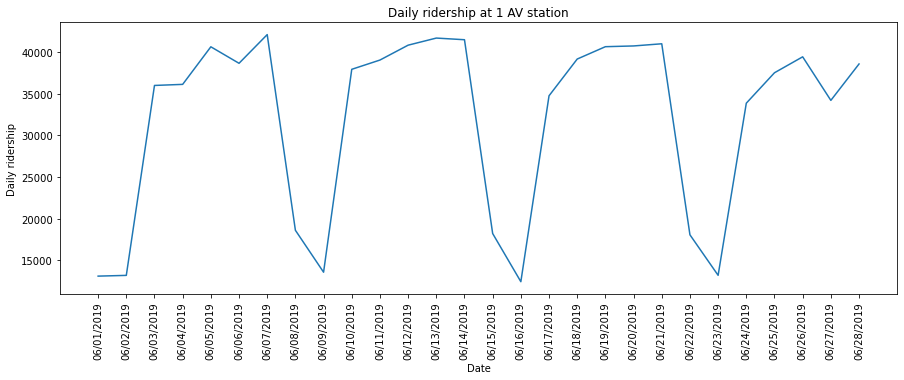

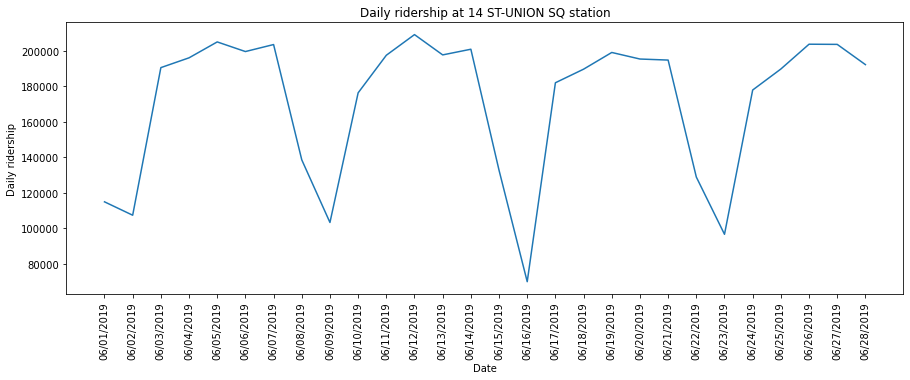

In [114]:
#Function for plotting monthly time series of stop
def plot_monthly_series(df, station):
    station_df = df.loc[df['STATION'] == station].copy()
    plt.figure(figsize = (15,5))
    plt.plot(station_df['DATE'], station_df['TOTAL RIDERSHIP'])
    plt.xticks(rotation = 'vertical')
    plt.xlabel('Date')
    plt.ylabel('Daily ridership')
    plt.title('Daily ridership at ' + station + ' station')
    plt.show()
plot_monthly_series(june_data_daily, '1 AV')
plot_monthly_series(june_data_daily, '14 ST-UNION SQ')

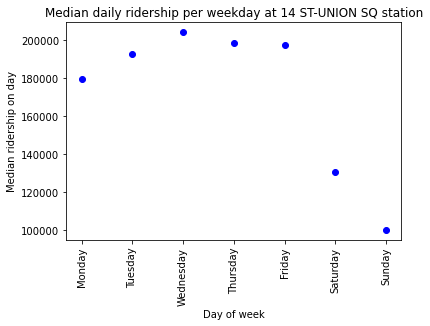

In [122]:
days = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
#Function for plotting median ridership at a station 
def plot_weekly(df, station):
    station_df = df.loc[df['STATION'] == station].copy()
    station_df['weekday'] = pd.to_datetime(station_df['DATE']).dt.dayofweek
    median_ridership = station_df.groupby(['weekday'])['TOTAL RIDERSHIP'].median()
    plt.plot(days, median_ridership, 'bo')
    plt.xticks(rotation = 'vertical')
    plt.xlabel('Day of week')
    plt.ylabel('Median ridership on day')
    plt.title('Median daily ridership per weekday at ' + station + ' station')
    plt.show()
plot_weekly(june_data_daily, '14 ST-UNION SQ')

In [120]:
june_data_hourly = june_data.groupby(['STATION', 'TIME'])[['TOTAL RIDERSHIP']].sum().reset_index()

In [121]:
june_data_hourly

,STATION,TIME,TOTAL RIDERSHIP
0,1 AV,00:00:00,113603.0
1,1 AV,04:00:00,20140.0
2,1 AV,08:00:00,88263.0
3,1 AV,12:00:00,210080.0
4,1 AV,16:00:00,188536.0
...,...,...,...
2380,ZEREGA AV,05:00:00,3743.0
2381,ZEREGA AV,09:00:00,34828.0
2382,ZEREGA AV,13:00:00,20917.0
2383,ZEREGA AV,17:00:00,28570.0


**Summary statistics for ridership across the whole month, indexed by station**

In [116]:
june_data_station_stats = june_data.groupby(['STATION'])['TOTAL RIDERSHIP']\
                            .agg([('MEAN', 'mean'),('MEDIAN', 'median'),('SUM', 'sum')])\
                            .reset_index().sort_values('MEDIAN', ascending = False).set_index('STATION')


In [117]:
june_data_station_stats

,MEAN,MEDIAN,SUM
STATION,,,
14 ST-UNION SQ,28884.969880,28541.0,4794905.0
TIMES SQ-42 ST,29366.463855,28500.0,4874833.0
34 ST-HERALD SQ,33574.556886,26438.0,5606951.0
34 ST-PENN STA,23433.621622,18321.0,7803396.0
59 ST COLUMBUS,19370.502994,16538.0,3234874.0
...,...,...,...
TOMPKINSVILLE,107.502994,106.0,17953.0
BEACH 105 ST,108.844311,77.0,18177.0
BROAD CHANNEL,61.532934,46.0,10276.0


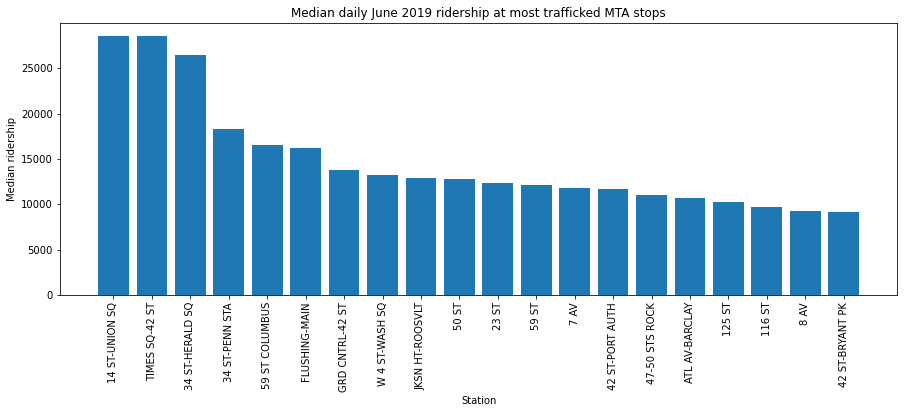

In [118]:
june_data_station_stats.sort_values('MEDIAN', ascending = False, inplace=True)
stations = june_data_station_stats.index
med_ridership = june_data_station_stats['MEDIAN']
plt.figure(figsize = (15,5))
plt.bar(stations[:20], med_ridership[:20])
plt.xticks(rotation='vertical')
plt.xlabel('Station')
plt.ylabel('Median ridership')
plt.title('Median daily June 2019 ridership at most trafficked MTA stops')
plt.show()

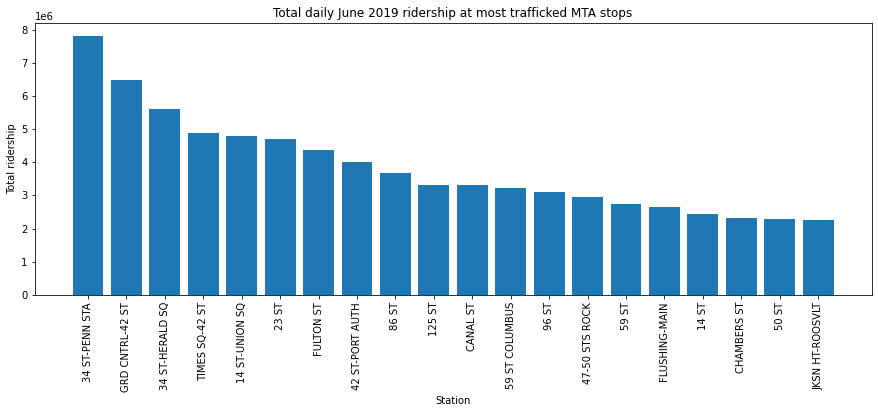

In [119]:
june_data_station_stats.sort_values('SUM', ascending = False, inplace=True)
stations = june_data_station_stats.index
total_ridership = june_data_station_stats['SUM']
plt.figure(figsize = (15,5))
plt.bar(stations[:20], total_ridership[:20])
plt.xticks(rotation='vertical')
plt.xlabel('Station')
plt.ylabel('Total ridership')
plt.title('Total daily June 2019 ridership at most trafficked MTA stops')
plt.show()